# Previous Trial Effects by Ambiguity Level

This notebook investigates whether **previous trial effects** differ based on **ambiguity level**.

**Hypothesis**: 
- In **high ambiguity** trials (uncertain probabilities), participants may rely more on previous trial outcomes
- In **low ambiguity** trials (clear probabilities), participants may rely more on the actual EV

**Analysis**:
1. Split data by ambiguity (low vs high)
2. Compare transition probabilities in each group
3. Compare model accuracy with/without sequential features in each group

In [1]:
# ============================================================================
# CONFIGURATION
# ============================================================================
TIMEFRAME = 'PRE'  # Options: 'PRE', 'POST'
# ============================================================================

import sys
sys.path.append('../../../')

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

from src.utils.io import load_features, save_results
from src.visualization.plots import set_style

np.random.seed(42)
set_style('whitegrid')

print(f"\n{'='*70}")
print(f"PREVIOUS TRIAL EFFECTS BY AMBIGUITY: {TIMEFRAME}-DECISION")
print(f"{'='*70}\n")


PREVIOUS TRIAL EFFECTS BY AMBIGUITY: PRE-DECISION



## 1. Load Data and Add Sequential Features

In [2]:
# Load pre-extracted features
features_path = f'../../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl'
feature_data = load_features(features_path, timeframe=TIMEFRAME)

merged_df = feature_data['merged_df'].copy()
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"\nAmbiguity distribution:")
print(merged_df['ambiguity'].describe())

Loaded 12511 trials from 97 subjects

Ambiguity distribution:
count    12511.000000
mean         2.998801
std          2.450811
min          0.000000
25%          0.000000
50%          3.000000
75%          6.000000
max          6.000000
Name: ambiguity, dtype: float64


In [3]:
# Extract trial number and sort
def extract_trial_number(trial_id):
    parts = trial_id.split('_')
    return int(parts[0])

merged_df['trial_number'] = merged_df['trial_id'].apply(extract_trial_number)
merged_df = merged_df.sort_values(['subject_id', 'trial_number']).reset_index(drop=True)

# Add sequential features
def add_sequential_features(df, group_col='subject_id'):
    df['prev_outcome'] = df.groupby(group_col)['outcome'].shift(1)
    df['prev_outcome_2'] = df.groupby(group_col)['outcome'].shift(2)
    df['running_invest_rate'] = df.groupby(group_col)['outcome'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df['recent_invest_rate_5'] = df.groupby(group_col)['outcome'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean().shift(1)
    )
    df['trial_position'] = df.groupby(group_col)['trial_number'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)
    )
    
    def count_consecutive(series):
        result = [0]
        count = 0
        for i in range(1, len(series)):
            if series.iloc[i-1] == series.iloc[i-2] if i > 1 else True:
                count += 1
            else:
                count = 0
            result.append(count)
        return pd.Series(result, index=series.index)
    
    df['consecutive_same'] = df.groupby(group_col)['outcome'].transform(count_consecutive)
    return df

merged_df = add_sequential_features(merged_df)
sequential_cols = ['prev_outcome', 'prev_outcome_2', 'running_invest_rate', 
                   'recent_invest_rate_5', 'trial_position', 'consecutive_same']

# Filter to valid trials (with previous outcome)
df_valid = merged_df[merged_df['prev_outcome'].notna()].copy()
print(f"Trials with valid sequential features: {len(df_valid)}")

Trials with valid sequential features: 12414


In [4]:
# Split by ambiguity level (discrete values: 0, 3, 6)
# Following the same method as notebooks/fusion_models/ambiguity_group_late_fusion.ipynb
df_valid['ambiguity_group'] = df_valid['ambiguity'].replace({0: 'Low', 3: 'Medium', 6: 'High'})

# Convert to categorical with proper ordering
df_valid['ambiguity_group'] = pd.Categorical(df_valid['ambiguity_group'], 
                                              categories=['Low', 'Medium', 'High'], 
                                              ordered=True)

print(f"Ambiguity values in data: {sorted(df_valid['ambiguity'].unique())}")
print(f"\nTrials by ambiguity group:")
print(df_valid['ambiguity_group'].value_counts().sort_index())

print(f"\nAmbiguity value by group:")
print(df_valid.groupby('ambiguity_group')['ambiguity'].agg(['min', 'max', 'mean']))

Ambiguity values in data: [np.int64(0), np.int64(3), np.int64(6)]

Trials by ambiguity group:
ambiguity_group
Low       4143
Medium    4129
High      4142
Name: count, dtype: int64

Ambiguity value by group:
                 min  max  mean
ambiguity_group                
Low                0    0   0.0
Medium             3    3   3.0
High               6    6   6.0


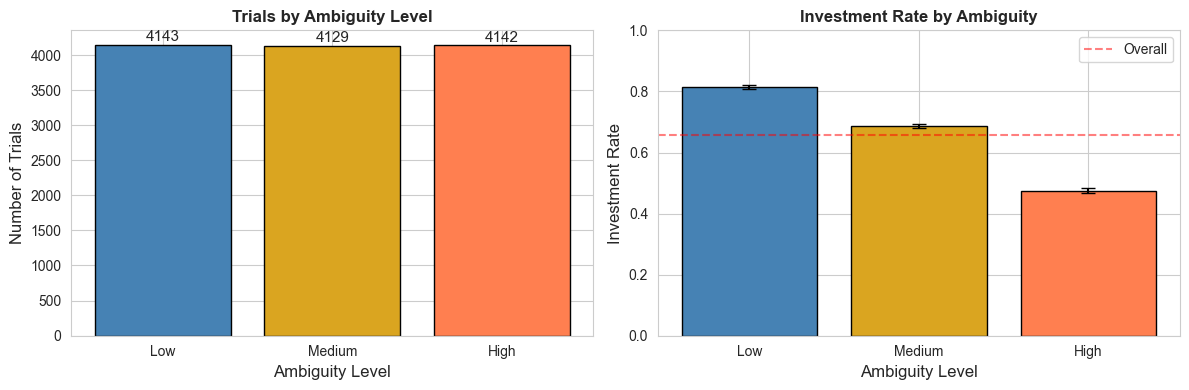

In [5]:
# Visualize ambiguity distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart of trials per ambiguity level
ax1 = axes[0]
counts = df_valid['ambiguity_group'].value_counts().sort_index()
colors = ['steelblue', 'goldenrod', 'coral']
bars = ax1.bar(counts.index, counts.values, color=colors, edgecolor='black')
ax1.set_xlabel('Ambiguity Level', fontsize=12)
ax1.set_ylabel('Number of Trials', fontsize=12)
ax1.set_title('Trials by Ambiguity Level', fontsize=12, fontweight='bold')

# Add value labels
for bar, count in zip(bars, counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count}', ha='center', fontsize=11)

# Investment rate by ambiguity group
ax2 = axes[1]
invest_by_group = df_valid.groupby('ambiguity_group')['outcome'].agg(['mean', 'sem'])
bars = ax2.bar(invest_by_group.index, invest_by_group['mean'], 
               yerr=invest_by_group['sem'], capsize=5, color=colors, edgecolor='black')
ax2.axhline(y=df_valid['outcome'].mean(), color='red', linestyle='--', alpha=0.5, label='Overall')
ax2.set_ylabel('Investment Rate', fontsize=12)
ax2.set_xlabel('Ambiguity Level', fontsize=12)
ax2.set_title('Investment Rate by Ambiguity', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.legend()

plt.tight_layout()
plt.show()

## 3. Transition Probabilities by Ambiguity

In [6]:
print("="*70)
print("TRANSITION PROBABILITIES BY AMBIGUITY")
print("="*70)

transition_results = []

for group in df_valid['ambiguity_group'].cat.categories:
    df_group = df_valid[df_valid['ambiguity_group'] == group]
    
    prev_invest = df_group[df_group['prev_outcome'] == 1]
    prev_keep = df_group[df_group['prev_outcome'] == 0]
    
    p_invest_after_invest = prev_invest['outcome'].mean()
    p_invest_after_keep = prev_keep['outcome'].mean()
    
    # Chi-square test
    contingency = pd.crosstab(df_group['prev_outcome'], df_group['outcome'])
    chi2, p_value, _, _ = chi2_contingency(contingency)
    
    transition_results.append({
        'Ambiguity': group,
        'N': len(df_group),
        'P(I|I)': p_invest_after_invest,
        'P(I|K)': p_invest_after_keep,
        'Difference': p_invest_after_invest - p_invest_after_keep,
        'Chi2': chi2,
        'p-value': p_value
    })
    
    print(f"\n{group} Ambiguity (n={len(df_group)}):")
    print(f"  P(INVEST | prev=INVEST) = {p_invest_after_invest:.3f}")
    print(f"  P(INVEST | prev=KEEP)   = {p_invest_after_keep:.3f}")
    print(f"  Difference: {p_invest_after_invest - p_invest_after_keep:.3f}")
    print(f"  Chi-square: χ²={chi2:.2f}, p={p_value:.2e}")

transition_df = pd.DataFrame(transition_results)
print("\n" + transition_df.to_string(index=False))

TRANSITION PROBABILITIES BY AMBIGUITY

Low Ambiguity (n=4143):
  P(INVEST | prev=INVEST) = 0.858
  P(INVEST | prev=KEEP)   = 0.724
  Difference: 0.134
  Chi-square: χ²=107.33, p=3.76e-25

Medium Ambiguity (n=4129):
  P(INVEST | prev=INVEST) = 0.762
  P(INVEST | prev=KEEP)   = 0.548
  Difference: 0.214
  Chi-square: χ²=198.47, p=4.52e-45

High Ambiguity (n=4142):
  P(INVEST | prev=INVEST) = 0.550
  P(INVEST | prev=KEEP)   = 0.334
  Difference: 0.217
  Chi-square: χ²=176.85, p=2.36e-40

Ambiguity    N   P(I|I)   P(I|K)  Difference       Chi2      p-value
      Low 4143 0.858268 0.724240    0.134028 107.333989 3.761281e-25
   Medium 4129 0.762082 0.548297    0.213784 198.465527 4.515382e-45
     High 4142 0.550483 0.333564    0.216919 176.848205 2.363839e-40


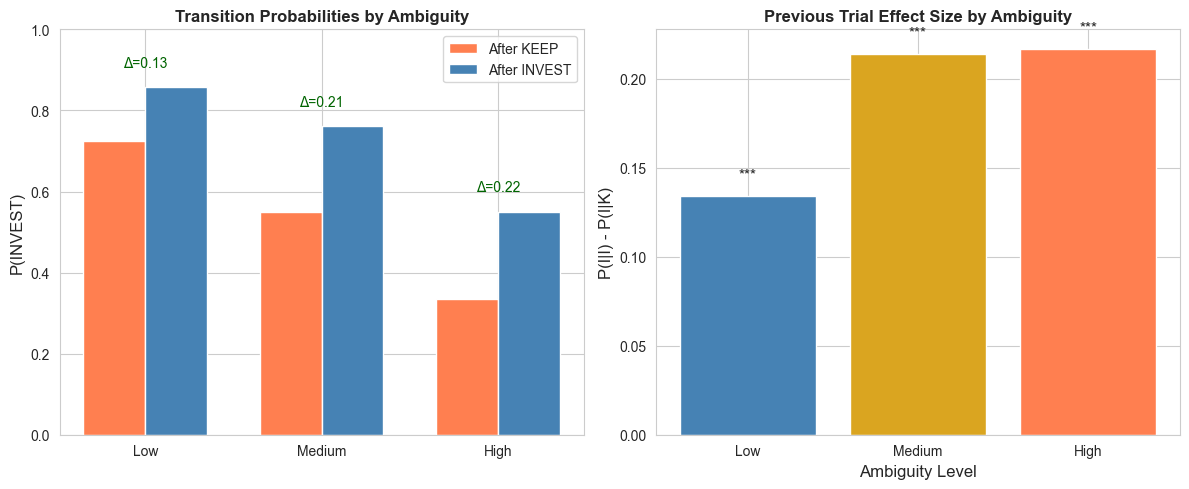

In [7]:
# Visualize transition probabilities by ambiguity
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Transition probabilities comparison
ax1 = axes[0]
x = np.arange(len(transition_df))
width = 0.35

bars1 = ax1.bar(x - width/2, transition_df['P(I|K)'], width, label='After KEEP', color='coral')
bars2 = ax1.bar(x + width/2, transition_df['P(I|I)'], width, label='After INVEST', color='steelblue')

ax1.set_ylabel('P(INVEST)', fontsize=12)
ax1.set_title('Transition Probabilities by Ambiguity', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(transition_df['Ambiguity'])
ax1.legend()
ax1.set_ylim(0, 1)

# Add difference annotations
for i, (idx, row) in enumerate(transition_df.iterrows()):
    ax1.annotate(f"Δ={row['Difference']:.2f}", 
                 xy=(i, max(row['P(I|I)'], row['P(I|K)']) + 0.05),
                 ha='center', fontsize=10, color='darkgreen')

# 2. Effect size (difference) comparison
ax2 = axes[1]
colors = ['steelblue', 'goldenrod', 'coral']
bars = ax2.bar(transition_df['Ambiguity'], transition_df['Difference'], color=colors)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('P(I|I) - P(I|K)', fontsize=12)
ax2.set_xlabel('Ambiguity Level', fontsize=12)
ax2.set_title('Previous Trial Effect Size by Ambiguity', fontsize=12, fontweight='bold')

# Add significance stars
for i, (idx, row) in enumerate(transition_df.iterrows()):
    sig = '***' if row['p-value'] < 0.001 else '**' if row['p-value'] < 0.01 else '*' if row['p-value'] < 0.05 else 'ns'
    ax2.text(i, row['Difference'] + 0.01, sig, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

## 4. Model Comparison by Ambiguity

In [8]:
def evaluate_model(X, y, subjects, name, verbose=False):
    """Evaluate model using LOSO CV."""
    logo = LeaveOneGroupOut()
    accs = []
    
    unique_subjects = np.unique(subjects)
    if len(unique_subjects) < 3:
        from sklearn.model_selection import cross_val_score
        model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
        scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        return {'accuracy': np.mean(scores), 'accuracy_sem': stats.sem(scores)}
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        accs.append(accuracy_score(y[test_idx], y_pred))
    
    return {'accuracy': np.mean(accs), 'accuracy_sem': stats.sem(accs)}

def weighted_late_fusion(X_modalities, y, subjects, modality_names=None):
    """Weighted late fusion with optional weight tracking."""
    logo = LeaveOneGroupOut()
    accs = []
    all_weights = []
    
    unique_subjects = np.unique(subjects)
    if len(unique_subjects) < 3:
        return {'accuracy': 0.5, 'accuracy_sem': 0.0, 'weights': {}}
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        y_train, y_test = y[train_idx], y[test_idx]
        train_subjects = subjects[train_idx]
        
        n_inner = min(5, len(np.unique(train_subjects)) - 1)
        if n_inner < 2:
            n_inner = 2
        
        train_probs = np.zeros((len(train_idx), len(X_modalities)))
        gkf_inner = GroupKFold(n_splits=n_inner)
        
        for inner_train_idx, inner_val_idx in gkf_inner.split(
            X_modalities[0][train_idx], y_train, train_subjects
        ):
            abs_inner_train = train_idx[inner_train_idx]
            abs_inner_val = train_idx[inner_val_idx]
            
            for mod_i, X in enumerate(X_modalities):
                model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
                model.fit(X[abs_inner_train], y[abs_inner_train])
                train_probs[inner_val_idx, mod_i] = model.predict_proba(X[abs_inner_val])[:, 1]
        
        test_probs = []
        for X in X_modalities:
            model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
            model.fit(X[train_idx], y_train)
            test_probs.append(model.predict_proba(X[test_idx])[:, 1])
        test_probs = np.column_stack(test_probs)
        
        meta = LogisticRegression(random_state=42, max_iter=1000)
        meta.fit(train_probs, y_train)
        y_pred = meta.predict(test_probs)
        accs.append(accuracy_score(y_test, y_pred))
        all_weights.append(meta.coef_[0])
    
    # Calculate normalized weights
    avg_weights = np.mean(all_weights, axis=0)
    norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))
    
    weights_dict = {}
    if modality_names:
        weights_dict = dict(zip(modality_names, norm_weights))
    
    return {'accuracy': np.mean(accs), 'accuracy_sem': stats.sem(accs), 'weights': weights_dict}

In [9]:
print("\n" + "="*70)
print("MODEL COMPARISON BY AMBIGUITY")
print("="*70)

model_results = []
weights_by_group = {}  # Store weights for visualization

modality_names_baseline = ['Physio', 'Behavior', 'Gaze']
modality_names_with_seq = ['Physio', 'Behavior', 'Gaze', 'Sequential']

for group in df_valid['ambiguity_group'].cat.categories:
    print(f"\n--- {group} Ambiguity ---")
    df_group = df_valid[df_valid['ambiguity_group'] == group].copy()
    df_group = df_group.reset_index(drop=True)
    
    # Prepare features
    X_physio = StandardScaler().fit_transform(
        SimpleImputer(strategy='mean').fit_transform(df_group[physio_cols]))
    X_behavior = StandardScaler().fit_transform(
        SimpleImputer(strategy='mean').fit_transform(df_group[behavior_cols]))
    X_gaze = StandardScaler().fit_transform(
        SimpleImputer(strategy='mean').fit_transform(df_group[gaze_cols])) if len(gaze_cols) > 0 else np.zeros((len(df_group), 1))
    X_sequential = StandardScaler().fit_transform(
        SimpleImputer(strategy='mean').fit_transform(df_group[sequential_cols]))
    
    y = df_group['outcome'].values
    subjects = df_group['subject_id'].values
    
    # Baseline: P+B+G
    results_baseline = weighted_late_fusion([X_physio, X_behavior, X_gaze], y, subjects, modality_names_baseline)
    print(f"  Baseline (P+B+G): {results_baseline['accuracy']:.3f}")
    print(f"    Weights: {results_baseline['weights']}")
    
    # With Sequential: P+B+G+S
    results_with_seq = weighted_late_fusion([X_physio, X_behavior, X_gaze, X_sequential], y, subjects, modality_names_with_seq)
    print(f"  With Sequential: {results_with_seq['accuracy']:.3f}")
    print(f"    Weights: {results_with_seq['weights']}")
    
    # Sequential only
    results_seq = evaluate_model(X_sequential, y, subjects, "Sequential")
    print(f"  Sequential Only: {results_seq['accuracy']:.3f}")
    
    improvement = results_with_seq['accuracy'] - results_baseline['accuracy']
    print(f"  Improvement: {improvement:+.3f}")
    
    # Store weights for plotting
    weights_by_group[group] = {
        'baseline': results_baseline,
        'with_seq': results_with_seq
    }
    
    model_results.append({
        'Ambiguity': group,
        'N': len(df_group),
        'Baseline': results_baseline['accuracy'],
        'Baseline_SEM': results_baseline['accuracy_sem'],
        'With_Sequential': results_with_seq['accuracy'],
        'With_Seq_SEM': results_with_seq['accuracy_sem'],
        'Sequential_Only': results_seq['accuracy'],
        'Improvement': improvement
    })

model_df = pd.DataFrame(model_results)
print("\n" + model_df.to_string(index=False))


MODEL COMPARISON BY AMBIGUITY

--- Low Ambiguity ---
  Baseline (P+B+G): 0.806
    Weights: {'Physio': np.float64(0.03562505077254799), 'Behavior': np.float64(0.9528968546165759), 'Gaze': np.float64(0.011478094610876123)}
  With Sequential: 0.806
    Weights: {'Physio': np.float64(0.024378357592272203), 'Behavior': np.float64(0.44523622743061336), 'Gaze': np.float64(0.011327012971059309), 'Sequential': np.float64(0.5190584020060551)}
  Sequential Only: 0.585
  Improvement: +0.000

--- Medium Ambiguity ---
  Baseline (P+B+G): 0.684
    Weights: {'Physio': np.float64(0.09240113224024832), 'Behavior': np.float64(0.8710601526737032), 'Gaze': np.float64(0.03653871508604851)}
  With Sequential: 0.718
    Weights: {'Physio': np.float64(0.013671472824074406), 'Behavior': np.float64(0.09249145345015017), 'Gaze': np.float64(0.011578231459072703), 'Sequential': np.float64(0.8822588422667027)}
  Sequential Only: 0.667
  Improvement: +0.034

--- High Ambiguity ---
  Baseline (P+B+G): 0.582
    Wei

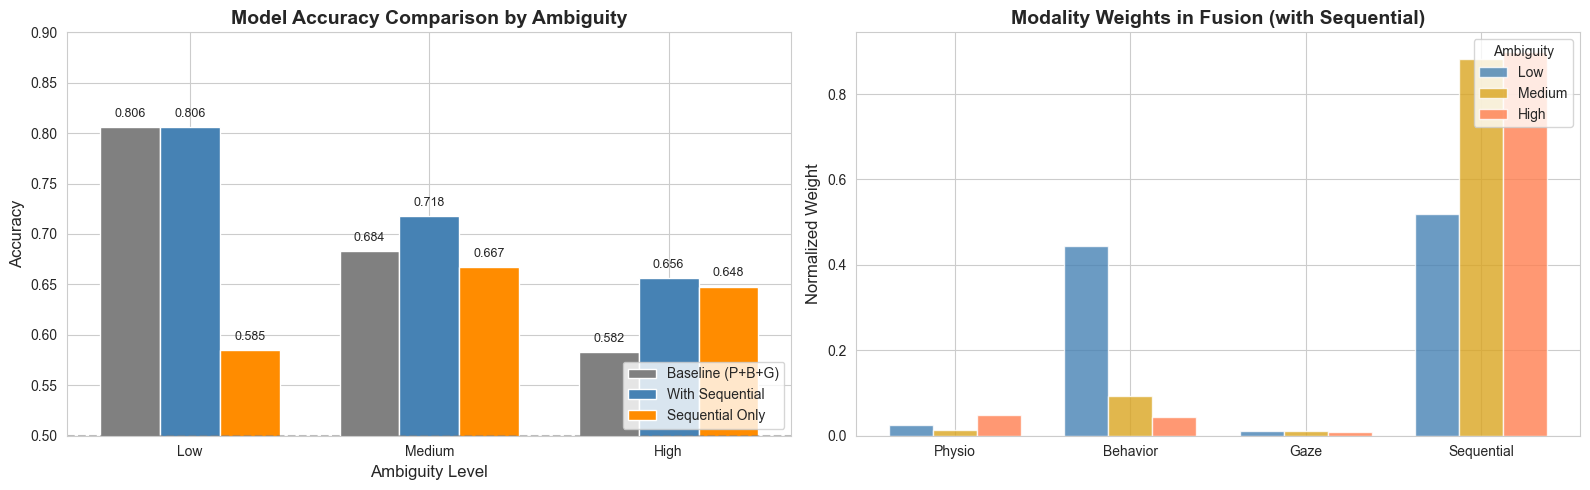

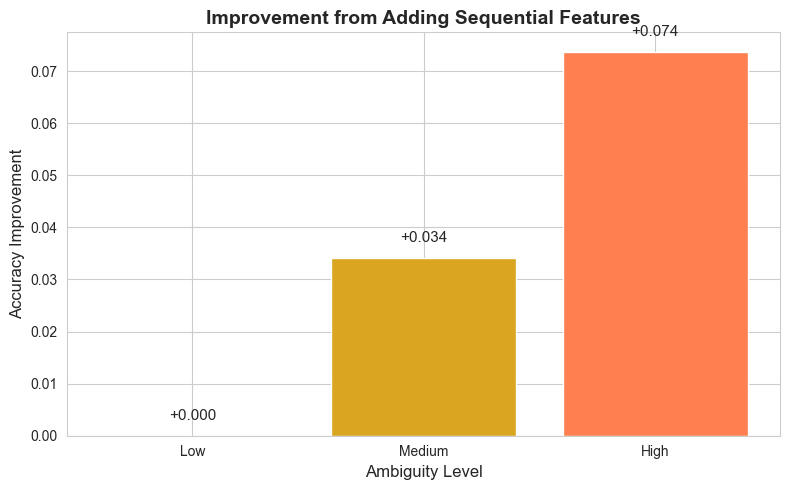

In [10]:
# Visualize model comparison (like in previous_trial_effects.ipynb)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

groups = list(df_valid['ambiguity_group'].cat.categories)
ambiguity_colors = ['steelblue', 'goldenrod', 'coral']

# 1. Model accuracy comparison by ambiguity group
ax1 = axes[0]
x = np.arange(len(groups))
width = 0.25

for i, group in enumerate(groups):
    row = model_df[model_df['Ambiguity'] == group].iloc[0]
    bars1 = ax1.bar(i - width, row['Baseline'], width, 
                    label='Baseline (P+B+G)' if i == 0 else '', color='gray')
    bars2 = ax1.bar(i, row['With_Sequential'], width,
                    label='With Sequential' if i == 0 else '', color='steelblue')
    bars3 = ax1.bar(i + width, row['Sequential_Only'], width,
                    label='Sequential Only' if i == 0 else '', color='darkorange')
    
    # Add accuracy labels
    ax1.text(i - width, row['Baseline'] + 0.01, f"{row['Baseline']:.3f}", ha='center', fontsize=9)
    ax1.text(i, row['With_Sequential'] + 0.01, f"{row['With_Sequential']:.3f}", ha='center', fontsize=9)
    ax1.text(i + width, row['Sequential_Only'] + 0.01, f"{row['Sequential_Only']:.3f}", ha='center', fontsize=9)

ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Comparison by Ambiguity', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([f'{g}' for g in groups])
ax1.set_xlabel('Ambiguity Level', fontsize=12)
ax1.legend(loc='lower right')
ax1.set_ylim(0.5, 0.9)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# 2. Modality weights comparison (with sequential only) for each ambiguity group
ax2 = axes[1]
x = np.arange(len(modality_names_with_seq))
width = 0.25

for i, group in enumerate(groups):
    with_seq_weights = [weights_by_group[group]['with_seq']['weights'].get(n, 0) for n in modality_names_with_seq]
    offset = (i - 1) * width
    ax2.bar(x + offset, with_seq_weights, width, label=f'{group}', color=ambiguity_colors[i], alpha=0.8)

ax2.set_ylabel('Normalized Weight', fontsize=12)
ax2.set_title('Modality Weights in Fusion (with Sequential)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(modality_names_with_seq)
ax2.legend(title='Ambiguity', loc='upper right')

plt.tight_layout()
plt.show()

# Additional: Improvement comparison
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(model_df['Ambiguity'], model_df['Improvement'], color=ambiguity_colors)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Accuracy Improvement', fontsize=12)
ax.set_xlabel('Ambiguity Level', fontsize=12)
ax.set_title('Improvement from Adding Sequential Features', fontsize=14, fontweight='bold')

for i, (idx, row) in enumerate(model_df.iterrows()):
    ax.text(i, row['Improvement'] + 0.003, f"{row['Improvement']:+.3f}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()

In [11]:
print("\n" + "="*70)
print(f"SUMMARY: PREVIOUS TRIAL EFFECTS BY AMBIGUITY ({TIMEFRAME})")
print("="*70)

print("\n1. TRANSITION PROBABILITY DIFFERENCES (P(I|I) - P(I|K)):")
for _, row in transition_df.iterrows():
    print(f"   {row['Ambiguity']:6} Ambiguity: Δ = {row['Difference']:.3f} (p={row['p-value']:.2e})")

# Compare effect sizes across all 3 groups
low_effect = transition_df[transition_df['Ambiguity'] == 'Low']['Difference'].values[0]
med_effect = transition_df[transition_df['Ambiguity'] == 'Medium']['Difference'].values[0]
high_effect = transition_df[transition_df['Ambiguity'] == 'High']['Difference'].values[0]

print(f"\n   → Previous trial effect trend: Low={low_effect:.3f}, Med={med_effect:.3f}, High={high_effect:.3f}")
if high_effect > low_effect:
    print(f"   → Effect INCREASES with ambiguity (High - Low = {high_effect - low_effect:+.3f})")
else:
    print(f"   → Effect DECREASES with ambiguity (High - Low = {high_effect - low_effect:+.3f})")

print("\n2. MODEL IMPROVEMENT FROM SEQUENTIAL FEATURES:")
for _, row in model_df.iterrows():
    print(f"   {row['Ambiguity']:6} Ambiguity: {row['Improvement']:+.3f} ({row['Baseline']:.3f} → {row['With_Sequential']:.3f})")

print("\n3. INTERPRETATION:")
low_imp = model_df[model_df['Ambiguity'] == 'Low']['Improvement'].values[0]
med_imp = model_df[model_df['Ambiguity'] == 'Medium']['Improvement'].values[0]
high_imp = model_df[model_df['Ambiguity'] == 'High']['Improvement'].values[0]

if high_imp > low_imp + 0.01:
    print("   ✓ Sequential features help MORE in high ambiguity trials")
    print("   ✓ When probabilities are uncertain, participants rely more on past behavior")
elif low_imp > high_imp + 0.01:
    print("   ✓ Sequential features help MORE in low ambiguity trials")
    print("   ✓ Clear probability trials still show strong sequential effects")
else:
    print("   ~ Sequential features help SIMILARLY across ambiguity levels")
    print("   ~ Previous trial effects are consistent regardless of uncertainty")

print("\n" + "="*70)


SUMMARY: PREVIOUS TRIAL EFFECTS BY AMBIGUITY (PRE)

1. TRANSITION PROBABILITY DIFFERENCES (P(I|I) - P(I|K)):
   Low    Ambiguity: Δ = 0.134 (p=3.76e-25)
   Medium Ambiguity: Δ = 0.214 (p=4.52e-45)
   High   Ambiguity: Δ = 0.217 (p=2.36e-40)

   → Previous trial effect trend: Low=0.134, Med=0.214, High=0.217
   → Effect INCREASES with ambiguity (High - Low = +0.083)

2. MODEL IMPROVEMENT FROM SEQUENTIAL FEATURES:
   Low    Ambiguity: +0.000 (0.806 → 0.806)
   Medium Ambiguity: +0.034 (0.684 → 0.718)
   High   Ambiguity: +0.074 (0.582 → 0.656)

3. INTERPRETATION:
   ✓ Sequential features help MORE in high ambiguity trials
   ✓ When probabilities are uncertain, participants rely more on past behavior



## 5. Feature Importance by Ambiguity

In [12]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE BY AMBIGUITY (ALL MODALITIES)")
print("="*70)

# Compare feature importance across ambiguity groups for ALL modalities
importance_by_group = {}
all_importance_dfs = {}

for group in df_valid['ambiguity_group'].cat.categories:
    df_group = df_valid[df_valid['ambiguity_group'] == group].copy()
    
    # Combine ALL modalities
    X_all = np.hstack([
        StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(df_group[physio_cols])),
        StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(df_group[behavior_cols])),
        StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(df_group[gaze_cols])) if len(gaze_cols) > 0 else np.zeros((len(df_group), 1)),
        StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(df_group[sequential_cols]))
    ])
    all_cols = physio_cols + behavior_cols + (gaze_cols if len(gaze_cols) > 0 else ['gaze_placeholder']) + sequential_cols
    modality_labels = (['Physiology'] * len(physio_cols) + 
                       ['Behavior'] * len(behavior_cols) + 
                       ['Gaze'] * len(gaze_cols if len(gaze_cols) > 0 else ['gaze_placeholder']) + 
                       ['Sequential'] * len(sequential_cols))
    
    y_group = df_group['outcome'].values
    
    model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    model.fit(X_all, y_group)
    
    importance_by_group[group] = dict(zip(all_cols, np.abs(model.coef_[0])))
    
    # Create importance dataframe for this group
    all_importance_dfs[group] = pd.DataFrame({
        'Feature': all_cols,
        'Coefficient': np.abs(model.coef_[0]),
        'Type': modality_labels
    }).sort_values('Coefficient', ascending=False)

# Show top 15 features for each group
for group in df_valid['ambiguity_group'].cat.categories:
    print(f"\n--- {group} Ambiguity: Top 15 Features ---")
    print(all_importance_dfs[group].head(15).to_string(index=False))

# Total importance by modality for each group
print("\n--- Total Importance by Modality ---")
for group in df_valid['ambiguity_group'].cat.categories:
    modality_importance = all_importance_dfs[group].groupby('Type')['Coefficient'].sum().sort_values(ascending=False)
    print(f"\n{group} Ambiguity:")
    print(modality_importance.to_string())


FEATURE IMPORTANCE BY AMBIGUITY (ALL MODALITIES)

--- Low Ambiguity: Top 15 Features ---
                    Feature  Coefficient       Type
         gaze_velocity_mean     2.276340       Gaze
          gaze_velocity_std     1.246792       Gaze
     gaze_acceleration_mean     1.087854       Gaze
             fixation_ratio     0.945564       Gaze
              saccade_ratio     0.687259       Gaze
              reaction_time     0.612488   Behavior
          gaze_dispersion_x     0.566440       Gaze
           consecutive_same     0.563950 Sequential
        running_invest_rate     0.489282 Sequential
              saccade_count     0.421311       Gaze
            invest_variance     0.409736   Behavior
               pupil_cv_pre     0.387668 Physiology
      gaze_acceleration_std     0.320658       Gaze
           gaze_path_length     0.317337       Gaze
pupil_max_dilation_rate_pre     0.299600 Physiology

--- Medium Ambiguity: Top 15 Features ---
               Feature  Coefficient

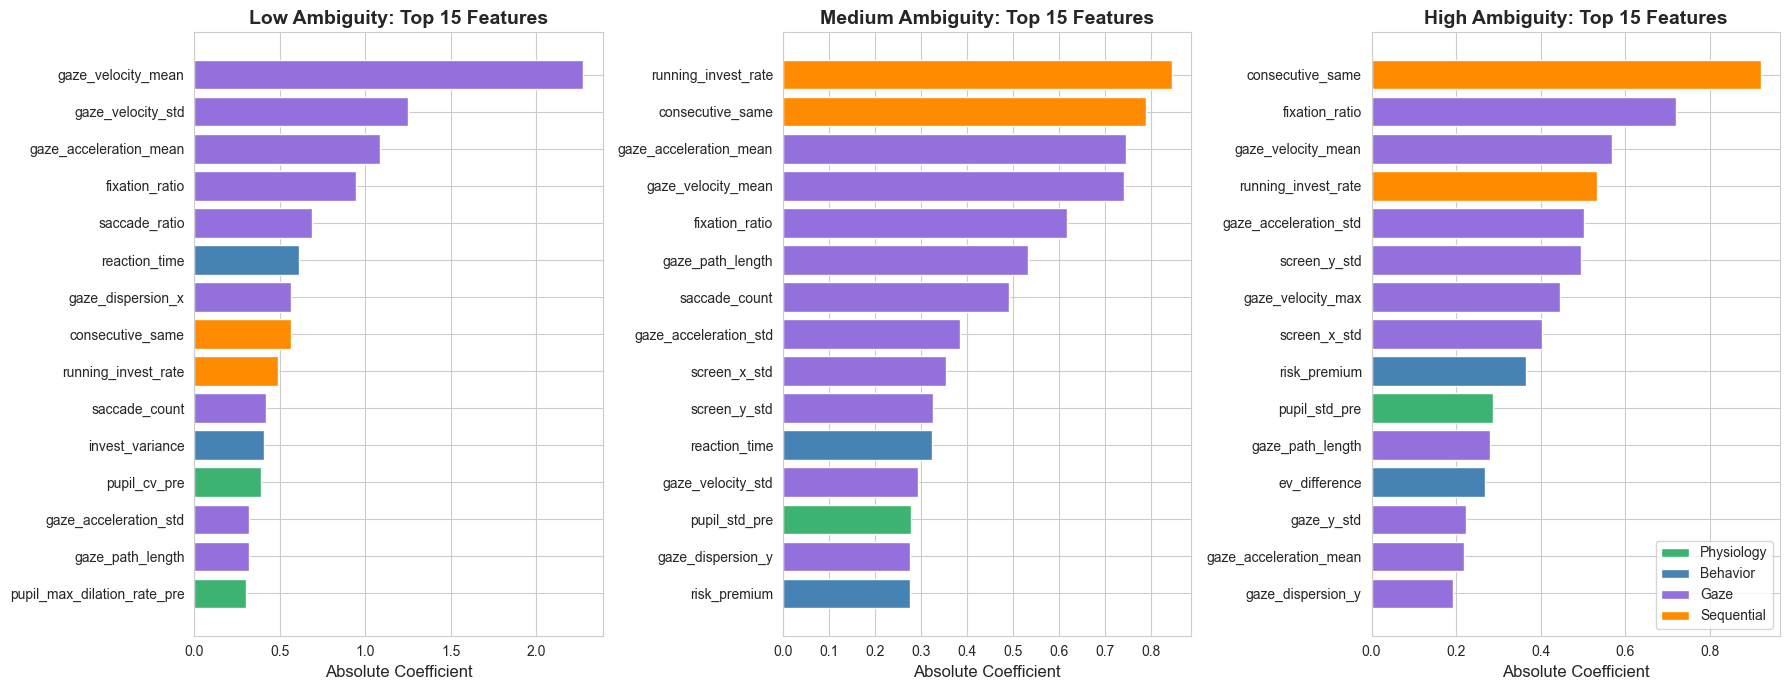

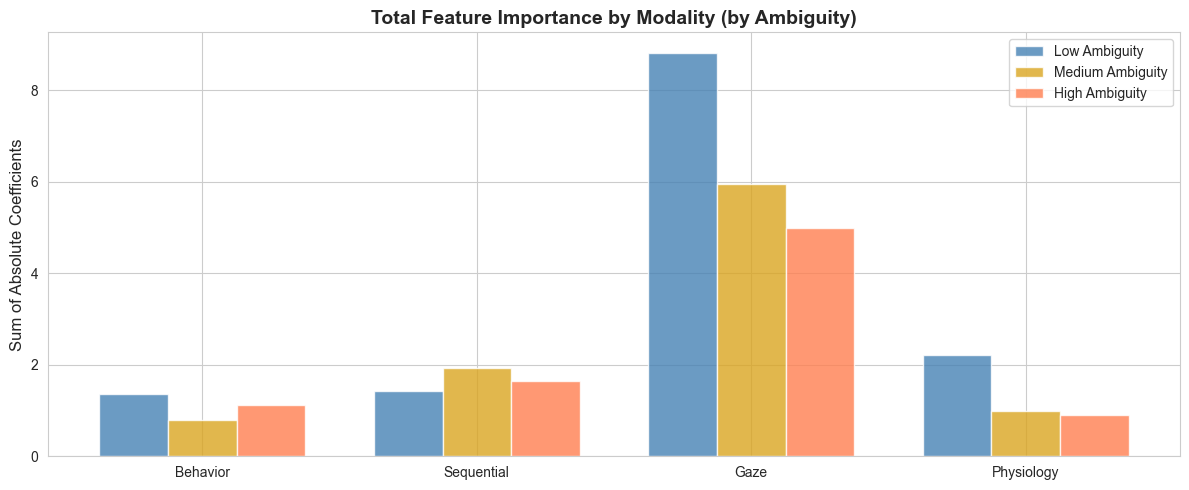

In [13]:
# Visualize feature importance (Top 15 features for each ambiguity group with all modalities)
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

# Color mapping for modalities
color_map = {
    'Physiology': 'mediumseagreen',
    'Behavior': 'steelblue', 
    'Gaze': 'mediumpurple',
    'Sequential': 'darkorange'
}

groups = list(df_valid['ambiguity_group'].cat.categories)

for idx, group in enumerate(groups):
    ax = axes[idx]
    top15 = all_importance_dfs[group].head(15)
    colors = [color_map[t] for t in top15['Type']]
    bars = ax.barh(top15['Feature'], top15['Coefficient'], color=colors)
    
    ax.set_xlabel('Absolute Coefficient', fontsize=12)
    ax.set_title(f'{group} Ambiguity: Top 15 Features', fontsize=14, fontweight='bold')
    ax.invert_yaxis()

# Add legend to last subplot
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=m) for m, c in color_map.items()]
axes[-1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Total importance by modality comparison
fig, ax = plt.subplots(figsize=(12, 5))

modality_order = ['Behavior', 'Sequential', 'Gaze', 'Physiology']
x = np.arange(len(modality_order))
width = 0.25

ambiguity_colors = ['steelblue', 'goldenrod', 'coral']

for i, group in enumerate(groups):
    modality_importance = all_importance_dfs[group].groupby('Type')['Coefficient'].sum()
    values = [modality_importance.get(m, 0) for m in modality_order]
    offset = (i - len(groups)/2 + 0.5) * width
    ax.bar(x + offset, values, width, label=f'{group} Ambiguity', color=ambiguity_colors[i], alpha=0.8)

ax.set_ylabel('Sum of Absolute Coefficients', fontsize=12)
ax.set_title('Total Feature Importance by Modality (by Ambiguity)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(modality_order)
ax.legend()

plt.tight_layout()
plt.show()

## 6. Save Results

In [14]:
import os

output_dir = f'../../../data/results/previous_trial_effects_{TIMEFRAME}'
os.makedirs(output_dir, exist_ok=True)

save_results(transition_df, f'{output_dir}/transitions_by_ambiguity_{TIMEFRAME}.csv')
save_results(model_df, f'{output_dir}/models_by_ambiguity_{TIMEFRAME}.csv')

# Save feature importance by ambiguity group
for group in df_valid['ambiguity_group'].cat.categories:
    save_results(all_importance_dfs[group], f'{output_dir}/feature_importance_{group}_ambiguity_{TIMEFRAME}.csv')

print(f"\n✓ Results saved to: {output_dir}/")

✓ Saved results to: ../../../data/results/previous_trial_effects_PRE/transitions_by_ambiguity_PRE.csv
✓ Saved results to: ../../../data/results/previous_trial_effects_PRE/models_by_ambiguity_PRE.csv
✓ Saved results to: ../../../data/results/previous_trial_effects_PRE/feature_importance_Low_ambiguity_PRE.csv
✓ Saved results to: ../../../data/results/previous_trial_effects_PRE/feature_importance_Medium_ambiguity_PRE.csv
✓ Saved results to: ../../../data/results/previous_trial_effects_PRE/feature_importance_High_ambiguity_PRE.csv

✓ Results saved to: ../../../data/results/previous_trial_effects_PRE/


## 7. Summary

In [15]:
print("\n" + "="*70)
print(f"SUMMARY: PREVIOUS TRIAL EFFECTS BY AMBIGUITY ({TIMEFRAME})")
print("="*70)

print("\n1. TRANSITION PROBABILITY DIFFERENCES:")
for _, row in transition_df.iterrows():
    print(f"   {row['Ambiguity']} Ambiguity: Δ = {row['Difference']:.3f} (p={row['p-value']:.2e})")

# Compare effect sizes
if len(transition_df) == 2:
    low_effect = transition_df[transition_df['Ambiguity'] == 'Low']['Difference'].values[0]
    high_effect = transition_df[transition_df['Ambiguity'] == 'High']['Difference'].values[0]
    print(f"\n   → Effect is {'STRONGER' if high_effect > low_effect else 'WEAKER'} in high ambiguity trials")
    print(f"   → Difference: {high_effect - low_effect:+.3f}")

print("\n2. MODEL IMPROVEMENT FROM SEQUENTIAL FEATURES:")
for _, row in model_df.iterrows():
    print(f"   {row['Ambiguity']} Ambiguity: {row['Improvement']:+.3f} ({row['Baseline']:.3f} → {row['With_Sequential']:.3f})")

print("\n3. INTERPRETATION:")
if len(model_df) == 2:
    low_imp = model_df[model_df['Ambiguity'] == 'Low']['Improvement'].values[0]
    high_imp = model_df[model_df['Ambiguity'] == 'High']['Improvement'].values[0]
    
    if high_imp > low_imp + 0.01:
        print("   ✓ Sequential features help MORE in high ambiguity trials")
        print("   ✓ When probabilities are uncertain, participants rely more on past behavior")
    elif low_imp > high_imp + 0.01:
        print("   ✓ Sequential features help MORE in low ambiguity trials")
        print("   ✓ Even with clear probabilities, past behavior influences decisions")
    else:
        print("   ~ Sequential features help SIMILARLY across ambiguity levels")
        print("   ~ Previous trial effects are consistent regardless of ambiguity")

print("\n" + "="*70)


SUMMARY: PREVIOUS TRIAL EFFECTS BY AMBIGUITY (PRE)

1. TRANSITION PROBABILITY DIFFERENCES:
   Low Ambiguity: Δ = 0.134 (p=3.76e-25)
   Medium Ambiguity: Δ = 0.214 (p=4.52e-45)
   High Ambiguity: Δ = 0.217 (p=2.36e-40)

2. MODEL IMPROVEMENT FROM SEQUENTIAL FEATURES:
   Low Ambiguity: +0.000 (0.806 → 0.806)
   Medium Ambiguity: +0.034 (0.684 → 0.718)
   High Ambiguity: +0.074 (0.582 → 0.656)

3. INTERPRETATION:

